# Overfitting

... Normally? A bad thing! But for our case it's good...

We use a new method to mix an overfitted model (our own) with a pretrained model (GPT-Neo-125M) and have them share eachothers traits. This way it's possible to finetune a model without having to retrain it. It's so fast it can be done in a second on CPU.

In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import content_aware_encode, train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, visualize_lr
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
seed = 970988852
#seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 970988852


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    'lr': 1e-4,
    "warmup_factor": 5,
    'scheduler': 'cycles_buildoff',
    "cycles": 25,
    "lr_end": 1e-6,
    "power": 0.6,
    #"freeze_from_steps": 1,
    'freeze_once': True,
    'freeze_layer_rate': 2e-5,
    'to_freeze_count': 155,
    "seed": seed,
    "num_epoch": 100
}

# Show me your LR!

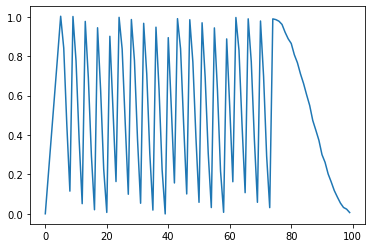

In [5]:
visualize_lr(config)

In [6]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model = model.to(device)
# set_pretrained_model_dropout(model.transformer.h, 0.0005)

Loaded empty model


# Test before training on a pretrained model!

In [7]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon-wielding demon-wielder, and I'm a dragon-wielding demon-wielder.

If you're interested in a good sword-wielder, here's the official guide.

Wielders

Wielders

Wielders are a very common problem in the sword-wielder world. In fact, swords are often used to combat a demon, such as a demon, and you may find a sword-wielder trying to take the sword away from you.

Wielders are usually used in the same


# Reviewing our dataset!

In [8]:
dataset = get_dataset(seed, tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
with open("data_train_sample.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
with open("data_train_sample2.txt", 'w') as f:
    for i, item in enumerate(dataset['train']):
        f.write(tokenizer.decode(item['input_ids']) + "\n")
        
print("RP review!")
to_see_rp = [
    'c "Fight',
    'c "What do you think of Lorem?'
]
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    for rp in list(to_see_rp):
        if rp in decoded: 
            print(decoded)
            print("-" * 10)
            to_see_rp.remove(rp)
            continue
    if len(to_see_rp) == 0:
        break
# Clean up
del to_see_rp

  0%|          | 0/2 [00:00<?, ?it/s]

RP review!
 a moment, I was worried."<p><msg>c "No need to. You're too nice to be like him."<p><msg>c "Fight"<d><scn>eckswimmingpool<msg>m "I didn't hesitate and kicked Naomi right in the stomach"<|endoftext|><d><scn>forest2<msg>Lo "You're right, it does look like a giant X."<p><msg>c "Guess it's time to get our hands dirty again."<d><scn>forest2<msg>Lo "
----------
Br "All of us are going to be busy with the search, and we can't really afford to spare someone right now. You'll be fine."<p><msg>c "What do you think of Lorem?"<d><scn>town4<msg>Br "He is a bit interesting."<|endoftext|><p><msg>c "Of course."<d><scn>facin3<msg>An "There is an opening soon where I can fit you in. I'll call you with all the details."<p><msg>c "I shall be looking forward
----------


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [9]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: False (freezing 155 out of 160 layers.)


Step,Training Loss
89,2.595900
178,1.794100
267,1.758700
356,1.749200
445,1.737700
534,1.736400
623,1.721400
712,1.716900
801,1.713200
890,1.710300


[90] set freeze_part_layers: True (freezing 155 out of 160 layers.)


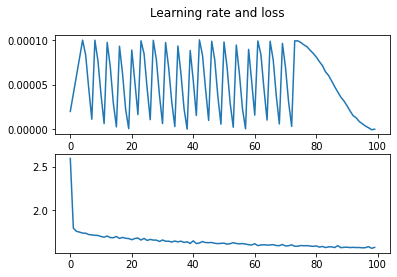

In [10]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

In [11]:
model.eval()
model.save_pretrained(saved_model_path)

In [12]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight",
    "Bite",
    "Attack"
]

for rp in test_rps:
    start_prompt = '<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."'
    print(f'{rp} -> {model_manager.say(start_prompt, rp)}')
    print(f'[sampled] {rp} -> {model_manager.say(start_prompt, rp, top_k = 50, top_p = 0.7)}')
    print("-" * 10)
    
print("Lowercase test")

for rp in test_rps:
    rp = rp[0].lower() + rp[1:]
    print(f'{rp} -> {model_manager.say("", rp)}')
    rp = rp.lower()
    print(f'{rp} -> {model_manager.say("", rp)}')
    print("-" * 10)

Visit Lorem -> park2<msg>Ry "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
[sampled] Visit Lorem -> park2<msg>Rz "Oh, [player_name], I didn't expect you to arrive so early."<|endoftext|>
----------
Meet with Lorem -> park2<msg>Rz "Hey [player_name]!"<|endoftext|>
[sampled] Meet with Lorem -> park2<msg>Ry "I have a few questions."<p><msg>c "Are you going to tell me about your first time on the water?"<d><scn>park2<msg>Ry "Sure. It's been quite a year since I've had time to practice, and I'm sure you'll enjoy this."<p
----------
Visit Adine -> park2<msg>Ad "Hey [player_name]!"<|endoftext|>
[sampled] Visit Adine -> park2<msg>Ad "Hey [player_name]!"<|endoftext|>
----------
Fight -> park2<msg>Rz "I'm not sure if I can do this, but I think I can."<|endoftext|>
[sampled] Fight -> park2<msg>Rz "I'm not sure if I could, but if you can't, I'm going to fight."<p><msg>c "I can't let you down. I'm not your friend."<d><scn>park2<msg>Ry "You should try something different."

In [13]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hello, [player_name]."', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
    ('<p><msg>Nm "Ah, nice. I like it here."', "Can you swim?"),
]

def prompt_test(model_manager, do_sample_test = True):
    for (past, prompt) in prompts:
        print(f"Prompt: {prompt}")
        reply = model_manager.say(past, prompt)
        print(f"Reply: {reply}")
        if do_sample_test:
            reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
            print(f"Reply [sampled]: {reply}")
        print("-" * 10)
        
prompt_test(model_manager)

Prompt: How are you?
Reply: park2<msg>Ry "Very nice."<|endoftext|>
Reply [sampled]: park2<msg>Ry "Very well."<p><msg>c "Hey [player_name]! How are you?"<|endoftext|>
----------
Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "He's a bit different."<|endoftext|>
Reply [sampled]: park2<msg>Ad "I think he is cute."<|endoftext|>
----------
Prompt: Oh my god, Adine. What is this?
Reply: o<msg>Ad "I was with Adine today"<d><scn>o<msg>Ad "Very nice"<|endoftext|>
Reply [sampled]: park1<msg>Ad "We don't really have time to get started, but we can probably get a few things done before we go."<p><msg>c "I think you should have stayed with us. If you're still going, you're probably not going to like it."<p><msg>c "You should have gone with him."<d><sc
----------
Prompt: What will we do here?
Reply: np1r<msg>Ry "I don't know. I don't know what to do."<p><msg>c "I'm not sure if I can do anything."<d><scn>np1r<msg>Ry "I'm not sure if I can do anything."<p><msg>c "I'm not sure if I can do anyt